
# Speech Recognition with Wav2Vec2

**Author**: [Moto Hira](moto@meta.com)_

This tutorial shows how to perform speech recognition using using
pre-trained models from wav2vec 2.0
[[paper](https://arxiv.org/abs/2006.11477)_].


## Preparation




In [16]:
import torch
import torchaudio

print(torch.__version__)
print(torchaudio.__version__)

torch.random.manual_seed(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(device)

2.5.1+cu124
2.5.1+cu124
cpu


In [17]:
import IPython
import matplotlib.pyplot as plt
from torchaudio.utils import download_asset

SPEECH_FILE = download_asset("/OSR_us_000_0061_8k.wav")

In [18]:
bundle = torchaudio.pipelines.WAV2VEC2_ASR_BASE_960H

print("Sample Rate:", bundle.sample_rate)

print("Labels:", bundle.get_labels())

Sample Rate: 16000
Labels: ('-', '|', 'E', 'T', 'A', 'O', 'N', 'I', 'H', 'S', 'R', 'D', 'L', 'U', 'M', 'W', 'C', 'F', 'G', 'Y', 'P', 'B', 'V', 'K', "'", 'X', 'J', 'Q', 'Z')


Model can be constructed as following. This process will automatically
fetch the pre-trained weights and load it into the model.




In [19]:
model = bundle.get_model().to(device)

print(model.__class__)

<class 'torchaudio.models.wav2vec2.model.Wav2Vec2Model'>


## Loading data

We will use the speech data from [VOiCES
dataset](https://iqtlabs.github.io/voices/)_, which is licensed under
Creative Commos BY 4.0.




In [20]:
IPython.display.Audio(SPEECH_FILE)

In [22]:
waveform, sample_rate = torchaudio.load(SPEECH_FILE)
waveform = waveform.to(device)

if sample_rate != bundle.sample_rate:
    waveform = torchaudio.functional.resample(waveform, sample_rate, bundle.sample_rate)

In [23]:
with torch.inference_mode():
    features, _ = model.extract_features(waveform)

The returned features is a list of tensors. Each tensor is the output of
a transformer layer.




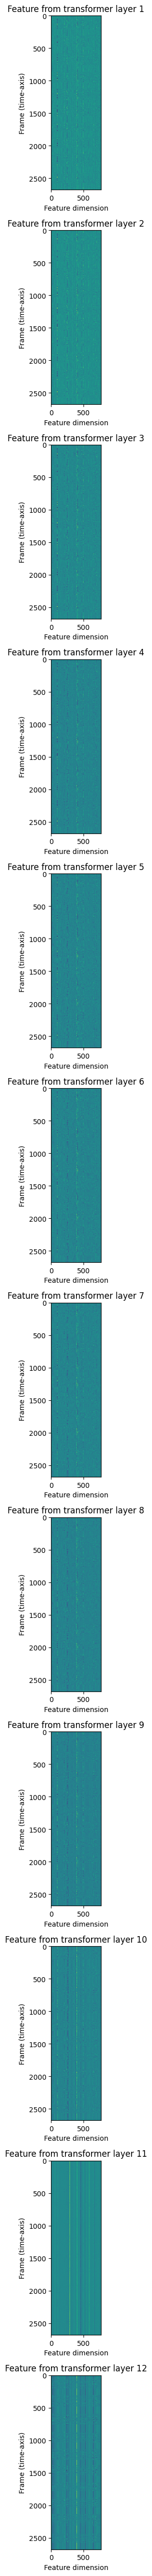

In [24]:
fig, ax = plt.subplots(len(features), 1, figsize=(16, 4.3 * len(features)))
for i, feats in enumerate(features):
    ax[i].imshow(feats[0].cpu(), interpolation="nearest")
    ax[i].set_title(f"Feature from transformer layer {i+1}")
    ax[i].set_xlabel("Feature dimension")
    ax[i].set_ylabel("Frame (time-axis)")
fig.tight_layout()

## Feature classification






In [11]:
with torch.inference_mode():
    emission, _ = model(waveform)

The output is in the form of logits. It is not in the form of
probability.

Let’s visualize this.




Class labels: ('-', '|', 'E', 'T', 'A', 'O', 'N', 'I', 'H', 'S', 'R', 'D', 'L', 'U', 'M', 'W', 'C', 'F', 'G', 'Y', 'P', 'B', 'V', 'K', "'", 'X', 'J', 'Q', 'Z')


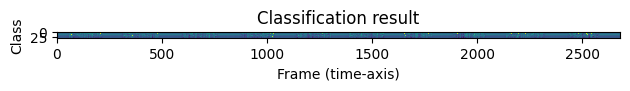

In [12]:
plt.imshow(emission[0].cpu().T, interpolation="nearest")
plt.title("Classification result")
plt.xlabel("Frame (time-axis)")
plt.ylabel("Class")
plt.tight_layout()
print("Class labels:", bundle.get_labels())

We can see that there are strong indications to certain labels across
the time line.




In [13]:
class GreedyCTCDecoder(torch.nn.Module):
    def __init__(self, labels, blank=0):
        super().__init__()
        self.labels = labels
        self.blank = blank

    def forward(self, emission: torch.Tensor) -> str:
        """Given a sequence emission over labels, get the best path string
        Args:
          emission (Tensor): Logit tensors. Shape `[num_seq, num_label]`.

        Returns:
          str: The resulting transcript
        """
        indices = torch.argmax(emission, dim=-1)  # [num_seq,]
        indices = torch.unique_consecutive(indices, dim=-1)
        indices = [i for i in indices if i != self.blank]
        return "".join([self.labels[i] for i in indices])

Now create the decoder object and decode the transcript.




In [14]:
decoder = GreedyCTCDecoder(labels=bundle.get_labels())
transcript = decoder(emission[0])

Let’s check the result and listen again to the audio.




In [15]:
print(transcript)
IPython.display.Audio(SPEECH_FILE)

THE|MUTE|MUFFLED|THE|HIGH|TONES|OF|THE|HORN|THE|GOLD|RING|FITS|ONLY|A|PIERCED|EAR|THE|OLD|PAN|WAS|COVERED|WITH|HARD|FUDGE|WATCH|THE|LOG|FLOAT|IN|THE|WIDE|RIVER|THE|NODE|ON|THE|STOCK|OF|WHEAT|GREW|DAILY|THE|HEAP|OF|FALLEN|LEAVES|WAS|SET|ON|FIRE|RIGHT|FAST|IF|YOU|WANT|TO|FINISH|EARLY|HIS|SHIRT|WAS|CLEAN|BUT|ONE|BUTTON|WAS|GONE|THE|BARREL|OF|BEER|WAS|A|BREW|OF|MALT|AND|HOPS|TIN|CANS|ARE|ABSENT|FROM|STORE|SHELVES|


The ASR model is fine-tuned using a loss function called Connectionist Temporal Classification (CTC).
The detail of CTC loss is explained
[here](https://distill.pub/2017/ctc/)_. In CTC a blank token (ϵ) is a
special token which represents a repetition of the previous symbol. In
decoding, these are simply ignored.


